In [1]:
# --- NO TYPE 3 FONTS IN PDF OUTPUT ---
import matplotlib as mpl
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["font.family"] = "DejaVu Sans"
mpl.rcParams["mathtext.fontset"] = "dejavusans"
mpl.rcParams["text.usetex"] = False

# Font sizes
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 12
# -------------------------------------

import os
import h5py
import yaml
import pickle
import shapely
import numpy as np
from utils import LatLonStandardScaler, StandardScaler

from sgptools.kernels import *
from sgptools.utils.gpflow import *
from sgptools.utils.metrics import *
from sgptools.utils.misc import *

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

2026-01-19 11:22:51.111781: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-19 11:22:51.112245: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-19 11:22:51.114038: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-19 11:22:51.119334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768843371.128728 1145812 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768843371.13

In [ ]:
mission_log = "../launch/data/Coverage-mission-2026-01-19-17-05-45"
num_samples = 5000
controller = "aqua2"

# data file
fname = os.path.join(mission_log,
                     "mission-log.hdf5")

# load data
with h5py.File(fname, "r") as f:
    print(f.keys())
    fence_vertices = f["fence_vertices"][:].astype(float)
    X = f["X"][:].astype(float)
    y = f["y"][:].astype(float)

    X_candidates = f["X_objective"][:].astype(float)

    X_init = f["X_init"][:].astype(float)
    y_init = f["y_init"][:].astype(float)

    for key in f.keys():
        if 'initial' in key:
            initial_path = f[key][:].astype(float)
        elif 'coverage' in key:
            sol_path = f[key][:].astype(float)

print(f'Mission Log: {mission_log}')
print(f'Number of initial data samples: {X_init.shape[0]}')
print(f'Number of solution data samples: {X.shape[0]}')
print(f'Number of reconstruction samples: {num_samples}')

if controller == 'mavros':
    X_scaler = LatLonStandardScaler()
    X_scaler.fit(X_candidates)
elif controller == 'aqua2':
    X_scaler = StandardScaler()
    X_scaler.fit(X_candidates)
    # Change variance/scale parameter to ensure all axis are scaled to the same value
    ind = np.argmax(X_scaler.var_)
    X_scaler.var_ = np.ones(X.shape[-1])*X_scaler.var_[ind]
    X_scaler.scale_ = np.ones(X.shape[-1])*X_scaler.scale_[ind]
    X_scaler.scale_ /= 10.0  # Scale to ensure an extent of ~10 units

X_candidates = X_scaler.transform(X_candidates)
y_scaler = StandardScaler()
y_scaler.fit(y)

y = y_scaler.transform(y)
X = X_scaler.transform(X)

y_init = y_scaler.transform(y_init)
X_init = X_scaler.transform(X_init)

initial_path = X_scaler.transform(initial_path)
sol_path = X_scaler.transform(sol_path)

fence_vertices = X_scaler.transform(fence_vertices)

sol_X, sol_y = cont2disc(sol_path, X, y)

<KeysViewHDF5 ['X', 'X_init', 'X_objective', 'coverage_path-21-29-48', 'fence_vertices', 'initial_path-21-22-46', 'y', 'y_init']>
Mission Log: ../launch/data/Coverage-mission-2026-01-17-21-22-46
Number of initial data samples: 544
Number of solution data samples: 732
Number of reconstruction samples: 5000


In [3]:
# Compute grid
distance = 0.3
len_x = max(X_candidates[:, 0])-min(X_candidates[:, 0])
len_y = max(X_candidates[:, 1])-min(X_candidates[:, 1])
num_x = int(np.ceil(len_x/distance))
num_y = int(np.ceil(len_y/distance))
extent = [min(X_candidates[:, 0]), max(X_candidates[:, 0]), 
          min(X_candidates[:, 1]), max(X_candidates[:, 1])]
grid_x, grid_y = np.mgrid[extent[0]:extent[1]:complex(num_x), 
                          extent[2]:extent[3]:complex(num_y)]
X_grid = np.stack([grid_x, grid_y], axis=-1)
X_grid = X_grid.reshape(-1, 2).astype(X_candidates.dtype)

print(num_x, num_y)

# Remove sensing locations outside the boundaries
pbounds = shapely.geometry.Polygon(fence_vertices)
points = shapely.points(X_grid)
inside_idx = shapely.contains(pbounds, points)
outside_idx = np.logical_not(inside_idx)

136 90


In [4]:
# Extract hyperparameters details from config.yaml
config_fname = os.path.join(mission_log, f"config.yaml")
with open(config_fname, 'r') as file:
    config = yaml.safe_load(file)
hyperparameter_config = config.get('hyperparameters', {})
kernel = hyperparameter_config.get('kernel_function', 'RBF')

# Use float32 and higher jitter for deep learning model based kernel functions
if kernel in ['Attentive', 'NeuralSpectral']:
    gpflow.config.set_default_float(np.float32)
    gpflow.config.set_default_jitter(1e-1)
else:
    gpflow.config.set_default_float(np.float64)
    gpflow.config.set_default_jitter(1e-6)

kernel_kwargs = hyperparameter_config.get('kernel', {})
kernel = get_kernel(kernel)(**kernel_kwargs)
noise_variance = float(hyperparameter_config.get('noise_variance', 1e-4))
optimizer_kwargs = config.get('optimizer', {})

W0000 00:00:1768843374.100720 1145812 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Max Variance: 0.6518024


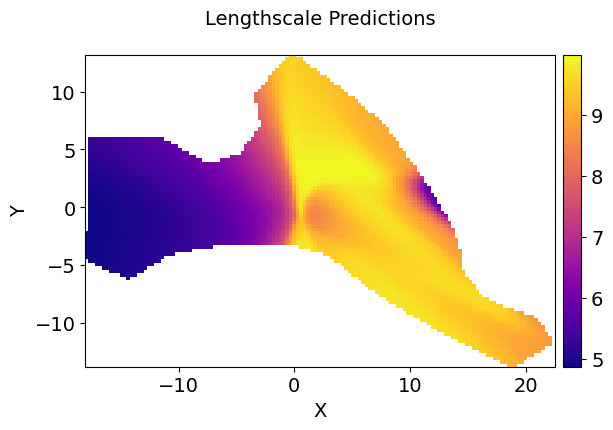

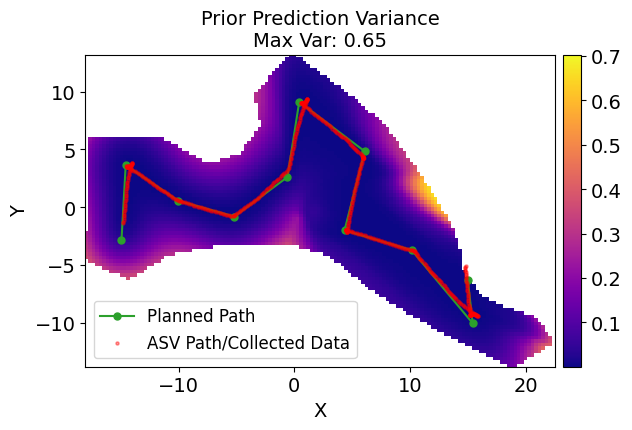

In [5]:
# Init GP model
_, _, _, gpr = get_model_params(np.vstack([X_init]).astype(np.float32), 
                                np.vstack([y_init]).astype(np.float32), 
                                kernel=kernel,
                                noise_variance=noise_variance,
                                return_model=True,
                                force_gp=True,
                                verbose=False,
                                max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr.likelihood, params['likelihood'])

mean, var_prior = gpr.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var_prior.numpy().max())

# ---- Plot lengthscale map ----
fig, ax = plt.subplots()

lengthscales = kernel.get_lengthscales(X_grid.astype(np.float32))
lengthscales[outside_idx] = np.nan

im = ax.imshow(
    lengthscales.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lengthscale Predictions\n')
fig.savefig("global_lengthscales", bbox_inches="tight")

plt.show()


# ---- Plot variance map (prior) ----
fig, ax = plt.subplots()

_, var = gpr.predict_f(X_grid.astype(np.float32))
var = var.numpy()
var_min = var.min()
var_max = var.max()

var[outside_idx] = np.nan

im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    vmin=var_min, 
    vmax=var_max,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # tweak size/pad as desired
fig.colorbar(im, cax=cax)

ax.plot(initial_path[:, 0], initial_path[:, 1], c='C2', marker='o', markersize=5, label='Planned Path')
ax.scatter(X_init[:, 0], X_init[:, 1], c='r', s=5, label='ASV Path/Collected Data', zorder=10, alpha=0.4)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend(loc='lower left')
ax.set_title(f'Prior Prediction Variance\nMax Var: {var_prior.numpy().max():.2f}')
fig.savefig("global_prior", bbox_inches="tight")

plt.show()

Max Variance: 0.22934833


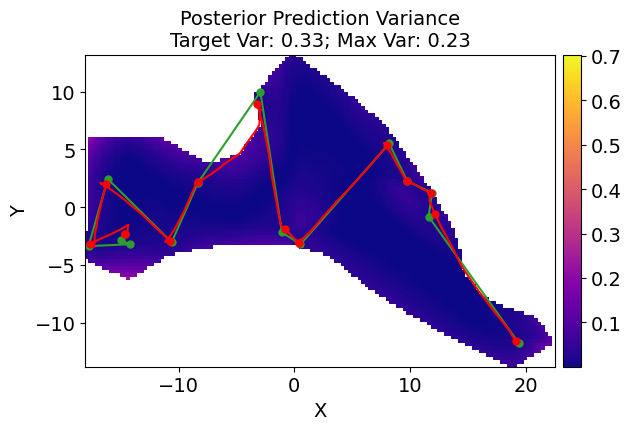

In [6]:
# Init GP model
_, _, _, gpr_post = get_model_params(np.vstack([X_init, sol_X]).astype(np.float32), 
                                     np.vstack([y_init, sol_y]).astype(np.float32), 
                                     kernel=kernel,
                                     noise_variance=noise_variance,
                                     return_model=True,
                                     force_gp=True,
                                     verbose=False,
                                     max_steps=0)

# Load pre-trained parameters
fname = os.path.join(mission_log, f"model_params.pkl")
with open(fname, 'rb') as handle:
    params = pickle.load(handle)
gpflow.utilities.multiple_assign(gpr_post.kernel, params['kernel'])
gpflow.utilities.multiple_assign(gpr_post.likelihood, params['likelihood'])

_, var_post = gpr_post.predict_f(X_candidates.astype(np.float32))
print("Max Variance:", var_post.numpy().max())

# ---- Plot variance map (posterior) ----

mean, var = gpr_post.predict_f(X_grid.astype(np.float32))
mean = mean.numpy()
var = var.numpy()
var[outside_idx] = np.nan

fig, ax = plt.subplots()

im = ax.imshow(
    var.reshape(num_x, num_y).T,
    origin='lower',
    extent=extent,
    vmin=var_min, 
    vmax=var_max,
    cmap='plasma'
)
ax.set_aspect('equal')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.08)  # thickness + spacing
fig.colorbar(im, cax=cax)

ax.plot(sol_path[:, 0], sol_path[:, 1], c='C2', marker='o', markersize=5, label='Planned Path')
ax.plot(X[:, 0], X[:, 1], c='r', markersize=5, label='ASV Path', zorder=10, alpha=1)
ax.scatter(sol_X[:, 0], sol_X[:, 1], c='r', s=25, label='Collected Data', zorder=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.legend(loc='upper right')
ax.set_title(f'Posterior Prediction Variance\nTarget Var: {var_prior.numpy().max()*0.5:.2f}; Max Var: {var_post.numpy().max():.2f}')
fig.savefig("global_post", bbox_inches="tight")

plt.show()